# Bosque Fray Jorge y su microclima

¿Por que es una zona de interes?
- Ecosistema Relictio
- Alberga especies en extincion
- Especies endémicas de Chile
- La conservación de esta área se debe principalmente a que en ella se presenta un bosque tipo valdiviano


**Bosque Valdiviano**:
Templado lluvioso u oceánico, con precipitaciones abundantes a lo largo del año y temperaturas frescas.

Como Fray Jorge no tiene preicpitaciones altas anualmente, la camanchaca es la que afecta directameante en como se sustenta este parque.

Más informacion puedes dar click [aqui](https://simbio.mma.gob.cl/CbaAP/Details/955#limites)

## Mapa interctivo

In [1]:
import zipfile
import xml.etree.ElementTree as ET
import folium

kmz_path = 'Bosque Fray Jorge.kmz'

# 2. Extraer el archivo .kml desde el .kmz
with zipfile.ZipFile(kmz_path, 'r') as z:
    kml_filename = [f for f in z.namelist() if f.endswith('.kml')][0]
    kml_content = z.read(kml_filename).decode(
        'utf-8', errors='ignore')  # leer como texto

# 3. Parsear el contenido del KML
root = ET.fromstring(kml_content)
ns = {'kml': 'http://www.opengis.net/kml/2.2'}

# 4. Extraer Placemarks con nombre y coordenadas
placemarks = []
for pm in root.findall('.//kml:Placemark', ns):
    name = pm.find('kml:name', ns)
    coords = pm.find('.//kml:coordinates', ns)
    placemarks.append({
        'Nombre': name.text if name is not None else 'Sin nombre',
        'Coordenadas': coords.text.strip() if coords is not None else 'Sin coordenadas'
    })

# 5. Crear mapa interactivo con folium
# Centrar el mapa en la primera coordenada
coord_str = placemarks[0]['Coordenadas'].split()[0]
lon, lat, *_ = map(float, coord_str.split(','))

m = folium.Map(location=[lat, lon], zoom_start=13)

# Agregar todos los marcadores
for pm in placemarks:
    coord_str = pm['Coordenadas'].split()[0]
    lon, lat, *_ = map(float, coord_str.split(','))
    folium.Marker(location=[lat, lon], popup=pm['Nombre']).add_to(m)

# 6. Mostrar mapa- SOLO EN JUPYTER
m

## Algunas imagenes del parque

<img src= "images/frayjorge.jpg" width="800" height="800" alt="Descripción de la imagen">

<img src= "images/mirador_frayjorge.webp" width="800" height="800" alt="Descripción de la imagen">

## Algunas preguntas que podemos responder con los datos de Fray Jorge:

### Datasets y prefiltrado de información

<img src="images/pagRec.png" width="800" height="800" alt="Descripción de la imagen">

In [2]:
# Dataframes a utilizar ya tratados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
df = pd.read_csv('csv/dataset01.csv', sep=';', encoding='utf-8')
df_temp = pd.read_csv('csv/TempA-B.csv', sep=';', encoding='utf-8')

# Mejora de legibilidad de los nombres de las columnas
df.rename(columns={
    'Fray Jorge Bosque[IEB]-Precipitación[mm]': 'PrecipitaciónBosque(mm)',
    'Fray Jorge Bosque[IEB]-Humedad Relativa[%]': 'H_RelativaBosque(%)',
    'Fray Jorge Bosque[IEB]-Temperatura de Suelo[°C]': 'TemperaturaBosqueS(C)',
    'Fray Jorge Quebrada [IEB]-Temperatura de Suelo[°C]': 'T_SueloQuebrada(C)',
    'Fray Jorge Quebrada [IEB]-Temperatura del Aire[°C]': 'T_AireQuebrada(C)',
}, inplace=True)


# Convertir las columnas relevantes a tipo numérico
df['PrecipitaciónBosque(mm)'] = pd.to_numeric(
    df['PrecipitaciónBosque(mm)'], errors='coerce')
df['H_RelativaBosque(%)'] = pd.to_numeric(
    df['H_RelativaBosque(%)'], errors='coerce')
df['TemperaturaBosqueS(C)'] = pd.to_numeric(
    df['TemperaturaBosqueS(C)'], errors='coerce')
df['T_SueloQuebrada(C)'] = pd.to_numeric(
    df['T_SueloQuebrada(C)'], errors='coerce')
df['T_AireQuebrada(C)'] = pd.to_numeric(
    df['T_AireQuebrada(C)'], errors='coerce')
# Convertir la columna 'Fecha' a tipo datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y')

print(df.head())
print(df_temp.head())

       Fecha  H_RelativaBosque(%)  PrecipitaciónBosque(mm)  \
0 2010-01-01                89.90                      3.7   
1 2010-02-01                87.02                      1.7   
2 2010-03-01                90.44                      4.7   
3 2010-04-01                86.34                      1.9   
4 2010-05-01                85.44                     34.3   

   TemperaturaBosqueS(C)  T_SueloQuebrada(C)  T_AireQuebrada(C)  
0                  19.49               23.80              16.83  
1                  19.65               23.01              16.71  
2                  18.00               21.89              16.27  
3                  14.73               18.43              13.53  
4                  12.27               15.32              12.48  
        Fecha Fray Jorge Bosque[IEB]-Temperatura del Aire[°C]
0  01/01/2010                                           13.21
1  01/02/2010                                           13.54
2  01/03/2010                                

## Entre los años 2010 y 2024, ¿se ha observado algún cambio en los parámetros climáticos que pueda atribuirse al cambio climático?

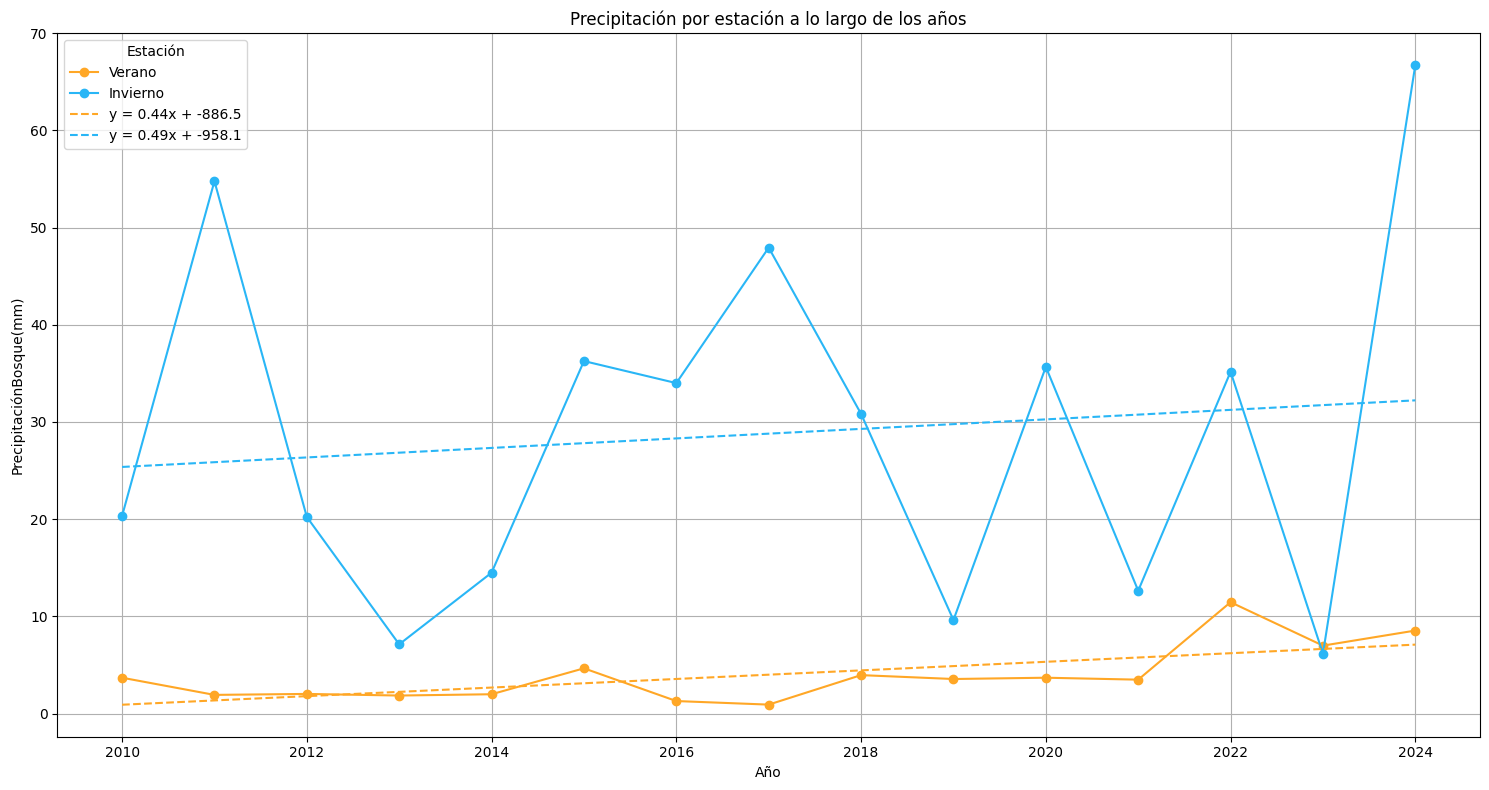

In [3]:
# Agrupar por estación del año y calcular promedios
# Filtramos por cada año

columnas_a_promediar = [
    'PrecipitaciónBosque(mm)',
    'H_RelativaBosque(%)',
    'T_SueloQuebrada(C)',
    'T_AireQuebrada(C)'

]
estaciones = ['Verano', 'Otoño', 'Invierno', 'Primavera']

# Definimos función para asignar estación en el hemisferio sur


def mes_a_estacion(mes):
    if mes in [12, 1, 2]:
        return estaciones[0]
    elif mes in [3, 4, 5]:
        return estaciones[1]
    elif mes in [6, 7, 8]:
        return estaciones[2]
    elif mes in [9, 10, 11]:
        return estaciones[3]


colores_estacion = {
    'Verano': '#FFA726',      # Naranja
    'Otoño': '#8D6E63',       # Café
    'Invierno': '#29B6F6',    # Celeste
    'Primavera': '#66BB6A'    # Verde
}

# Creamos una nueva columna 'Estación' para agrupar por estación del año
df['Estación'] = df['Fecha'].dt.month.apply(mes_a_estacion)
# Creamos una nueva columna 'Año' para agrupar por año
df['Año'] = df['Fecha'].dt.year
# Agrupamos por año y estación, calculando el promedio de las columnas seleccionadas
promedios_año_estacion = df.groupby(['Año', 'Estación'])[
    columnas_a_promediar].mean().reset_index()
# Ordenamos las estaciones de acuerdo a su orden natural
promedios_año_estacion['Estación'] = pd.Categorical(
    promedios_año_estacion['Estación'], categories=estaciones, ordered=True)

# Graficamos Precipitaciones en verano he ivierno
dt_verano = promedios_año_estacion[promedios_año_estacion['Estación'] == 'Verano']
dt_invierno = promedios_año_estacion[promedios_año_estacion['Estación'] == 'Invierno']
plt.figure(figsize=(15, 8))
plt.plot(dt_verano['Año'], dt_verano['PrecipitaciónBosque(mm)'], marker='o',
         linestyle='-', label='Verano', color=colores_estacion['Verano'])
plt.plot(dt_invierno['Año'], dt_invierno['PrecipitaciónBosque(mm)'], marker='o',
         linestyle='-', label='Invierno', color=colores_estacion['Invierno'])

# Regresion lineal para las precipitaciones
# Verano
x_verano = dt_verano['Año']
y_verano = dt_verano['PrecipitaciónBosque(mm)']
pendiente_verano, intercepto_verano, r_value_verano, p_value_verano, std_err_verano = linregress(
    x_verano, y_verano)
y_pred = pendiente_verano * x_verano + intercepto_verano
x_np = x_verano.to_numpy()

ecuacion = f'y = {pendiente_verano:.2f}x + {intercepto_verano:.1f}'
plt.plot(x_np, y_pred, linestyle='--',
         color=colores_estacion['Verano'], label=f'{ecuacion}')

# Invierno
x_invierno = dt_invierno['Año']
y_invierno = dt_invierno['PrecipitaciónBosque(mm)']
pendiente_invierno, intercepto_invierno, r_value_invierno, p_value_invierno, std_err_invierno = linregress(
    x_invierno, y_invierno)
y_pred_invierno = pendiente_invierno * x_invierno + intercepto_invierno
x_np_invierno = x_invierno.to_numpy()
ecuacion_invierno = f'y = {pendiente_invierno:.2f}x + {intercepto_invierno:.1f}'
plt.plot(x_np_invierno, y_pred_invierno, linestyle='--',
         color=colores_estacion['Invierno'], label=f'{ecuacion_invierno}')

plt.title(f'Precipitación por estación a lo largo de los años')
plt.xlabel('Año')
plt.ylabel('PrecipitaciónBosque(mm)')
plt.legend(title='Estación')
plt.grid(True)
plt.tight_layout()
plt.show()

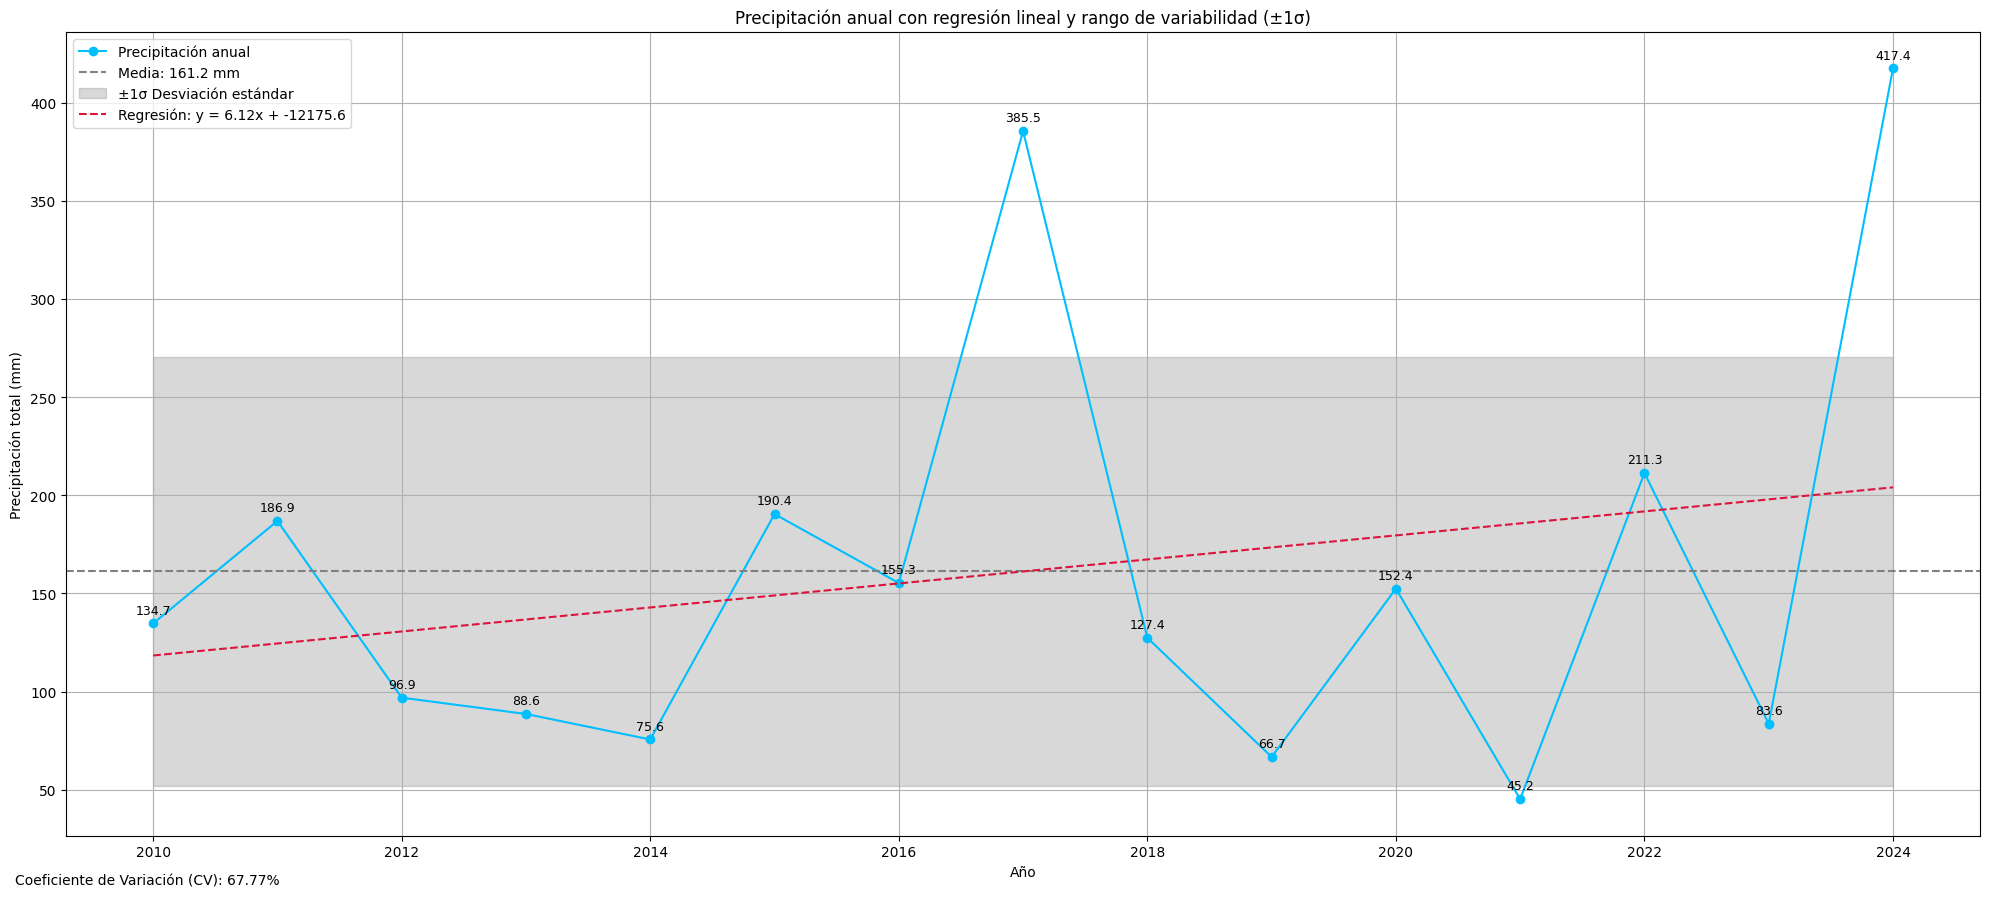

In [4]:
suma_precipitaciones = df.groupby('Año', observed=True)[
    'PrecipitaciónBosque(mm)'].sum().reset_index()

x = suma_precipitaciones['Año']
y = suma_precipitaciones['PrecipitaciónBosque(mm)']

# Cálculo de regresión lineal
pendiente, intercepto, r_value, p_value, std_err = linregress(x, y)
y_pred = pendiente * x + intercepto

# Cálculo de estadísticos
media = y.mean()
desv_std = y.std()
cv = (desv_std / media) * 100

# Gráfico
plt.figure(figsize=(20, 9))
plt.plot(x, y, marker='o', linestyle='-',
         label='Precipitación anual', color='deepskyblue')

# Media
plt.axhline(y=media, color='gray', linestyle='--',
            label=f'Media: {media:.1f} mm')

# Rango ±1 desviación estándar
plt.fill_between(x, media - desv_std, media + desv_std,
                 color='gray', alpha=0.3, label='±1σ Desviación estándar')

# Línea de regresión
plt.plot(x, y_pred, color='crimson', linestyle='--',
         label=f'Regresión: y = {pendiente:.2f}x + {intercepto:.1f}')

# Mostrar valores
for xi, yi in zip(x, y):
    plt.text(xi, yi + 5, f'{yi:.1f}', ha='center', fontsize=9)

# Leyendas y formato
plt.title('Precipitación anual con regresión lineal y rango de variabilidad (±1σ)')
plt.xlabel('Año')
plt.ylabel('Precipitación total (mm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
# Mostrar CV
plt.figtext(
    0.01, 0.01, f'Coeficiente de Variación (CV): {cv:.2f}%', fontsize=10)

plt.show()

## Humedad relativa por año

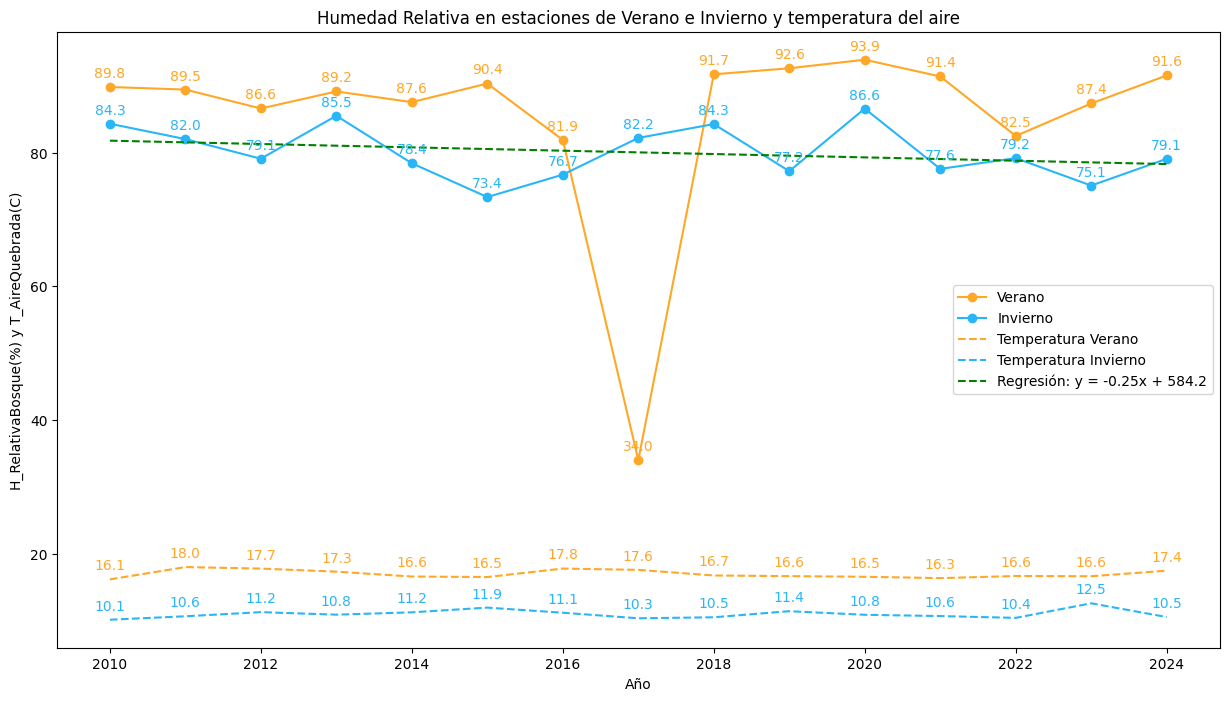

In [5]:
df_veranoH = promedios_año_estacion[promedios_año_estacion['Estación'] == 'Verano']
df_inviernoH = promedios_año_estacion[promedios_año_estacion['Estación'] == 'Invierno']
plt.figure(figsize=(15, 8))

# Graficamos para verano
plt.plot(df_veranoH['Año'], df_veranoH['H_RelativaBosque(%)'], marker='o',
         linestyle='-', label='Verano', color=colores_estacion['Verano'])
# Graficamos para invierno
plt.plot(df_inviernoH['Año'], df_inviernoH['H_RelativaBosque(%)'], marker='o',
         linestyle='-', label='Invierno', color=colores_estacion['Invierno'])
for i, valor in enumerate(df_veranoH['H_RelativaBosque(%)']):
    plt.text(df_veranoH['Año'].iloc[i], valor + 1,
             f'{valor:.1f}', ha='center', va='bottom', fontsize=10, color=colores_estacion['Verano'])
for i, valor in enumerate(df_inviernoH['H_RelativaBosque(%)']):
    plt.text(df_inviernoH['Año'].iloc[i], valor + 1,
             f'{valor:.1f}', ha='center', va='bottom', fontsize=10, color=colores_estacion['Invierno'])

plt.plot(df_veranoH['Año'], df_veranoH['T_AireQuebrada(C)'], linestyle='--',
         color=colores_estacion['Verano'], label='Temperatura Verano')
plt.plot(df_inviernoH['Año'], df_inviernoH['T_AireQuebrada(C)'], linestyle='--',
         color=colores_estacion['Invierno'], label='Temperatura Invierno')

for i, valor in enumerate(df_veranoH['T_AireQuebrada(C)']):
    plt.text(df_veranoH['Año'].iloc[i], valor + 1,
             f'{valor:.1f}', ha='center', va='bottom', fontsize=10, color=colores_estacion['Verano'])
for i, valor in enumerate(df_inviernoH['T_AireQuebrada(C)']):
    plt.text(df_inviernoH['Año'].iloc[i], valor + 1,
             f'{valor:.1f}', ha='center', va='bottom', fontsize=10, color=colores_estacion['Invierno'])

# Regresión lineal para invierno
x_invierno = df_inviernoH['Año'].to_numpy()
y_inviernoH = df_inviernoH['H_RelativaBosque(%)'].to_numpy()
pendiente_inviernoH, intercepto_inviernoH, r_value_inviernoH, p_value_inviernoH, std_err_inviernoH = linregress(
    x_invierno, y_inviernoH)
y_pred_inviernoH = pendiente_inviernoH * x_invierno + intercepto_inviernoH

plt.plot(x_invierno, y_pred_inviernoH, color='green', linestyle='--',
         label=f'Regresión: y = {pendiente_inviernoH:.2f}x + {intercepto_inviernoH:.1f}')

plt.title(
    'Humedad Relativa en estaciones de Verano e Invierno y temperatura del aire')
plt.xlabel('Año')
plt.ylabel('H_RelativaBosque(%) y T_AireQuebrada(C)')
plt.legend()
plt.show()

#🌡️ ¿Han aumentado las temperaturas mínimas en los últimos años, evidenciando calentamiento local?


###📘 Contexto, descripción y fuentes de los datos utilizados

Este proyecto tiene como propósito explorar y evidenciar posibles señales del cambio climático a partir de registros meteorológicos locales, específicamente desde La Serena, Chile, en base a lo que se puede observar directamente en nuestra ciudad.

Los datos provienen de la Dirección General de Aeronáutica Civil (DGAC), institución que gestiona y publica datos de estaciones meteorológicas a lo largo del país. Se utilizaron los registros de temperatura mínima y máxima horaria desde mediados del siglo XX hasta la actualidad.

Los archivos utilizados en este análisis son:

* tmin.csv: Contiene los valores de temperatura mínima diaria.

* tmax.csv: Contiene los valores de temperatura máxima diaria.

Cada archivo incluye:

* Código Nacional de la estación

* Fecha de medición

* Valor de temperatura

* Hora de captura del dato





In [6]:
# 🔧 Función para procesar cada archivo CSV
def procesar_csv(nombre_archivo, valor_nombre):
    # Leer CSV sin encabezado con separador ';'
    df = pd.read_csv(nombre_archivo, sep=';', header=None, names=[
                     'CodigoNacional', 'Fecha', valor_nombre, 'FechaHora_Valor'])

    # Convertir la columna 'Fecha' a datetime
    df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True, errors='coerce')

    # Normalizar la fecha para eliminar la hora
    df['Fecha'] = df['Fecha'].dt.normalize()

    # Convertir a número el valor de temperatura
    df[valor_nombre] = pd.to_numeric(df[valor_nombre], errors='coerce')

    # Eliminar filas sin fecha o formato válido
    df = df.dropna(subset=['Fecha'])

    # Dejar solo columnas que utilizaremos para la investigacion
    df = df[['CodigoNacional', 'Fecha', valor_nombre]]

    return df


# Procesar archivos tmax y tmin
df_tmax = procesar_csv("csv/tmax.csv", "TMax")
df_tmin = procesar_csv("csv/tmin.csv", "TMin")

# tomar desde cierto año en adelante
df_tmin = df_tmin[df_tmin['Fecha'].dt.year >= 1963]
df_tmax = df_tmax[df_tmax['Fecha'].dt.year >= 1963]

/var/folders/jv/dbjl1jdn6s5c_yt737h20gsw0000gn/T/ipykernel_28374/73896045.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True, errors='coerce')
/var/folders/jv/dbjl1jdn6s5c_yt737h20gsw0000gn/T/ipykernel_28374/73896045.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True, errors='coerce')


# La Serena

## 📈  Visualización de tendencias 

Mostramos cómo han evolucionado las temperaturas mínimas y máximas promedio a lo largo de los años.


In [7]:
df_tmin['Año'] = df_tmin['Fecha'].dt.year
df_grouped = df_tmin.groupby('Año')['TMin'].mean().reset_index()

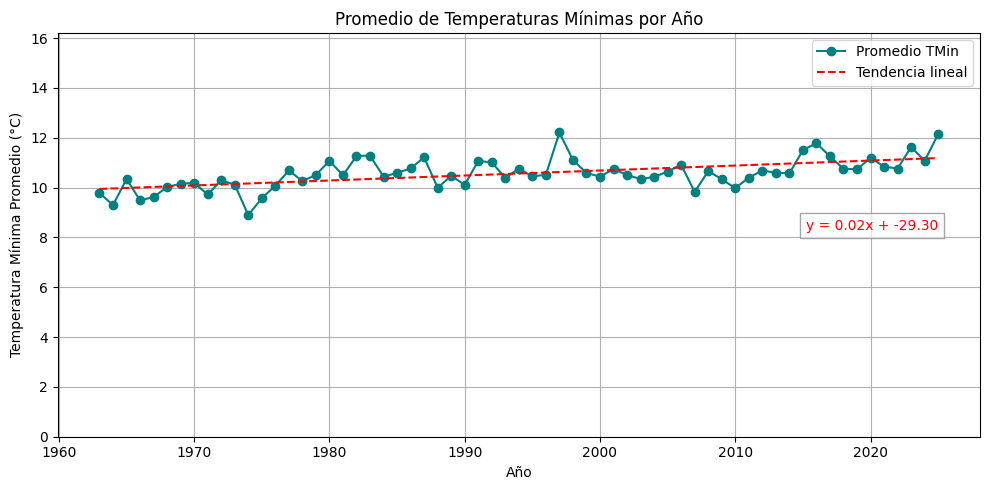

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(df_grouped['Año'], df_grouped['TMin'],
         marker='o', color='teal', label='Promedio TMin')

# 📉 Línea de tendencia (regresión lineal)
x = df_grouped['Año']
y = df_grouped['TMin']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), linestyle='--', color='red', label='Tendencia lineal')

# Ecuación de la línea de tendencia
pendiente = z[0]
interseccion = z[1]
eq_text = f'y = {pendiente:.2f}x + {interseccion:.2f}'

# Posicionar el texto más abajo del final de la línea
x_pos = x.iloc[-1]
y_pos = p(x_pos) - 3.0

plt.text(x_pos, y_pos, eq_text,
         fontsize=10, color='red', ha='right', va='bottom',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

plt.ylim(bottom=0)
plt.title('Promedio de Temperaturas Mínimas por Año')
plt.xlabel('Año')
plt.ylabel('Temperatura Mínima Promedio (°C)')
plt.grid(True)
plt.legend()
plt.tight_layout()
y_max = df_grouped['TMin'].max()
plt.ylim(bottom=0, top=y_max + 4)

plt.show()

### ¿El aumento de temperaturas se manifiesta tanto en verano como en invierno?

In [9]:
def calcular_promedios_por_estacion(df_tmin, df_tmax, meses_estacion, nombre_estacion):
    # Filtrar por los meses de la estación
    df_tmin_est = df_tmin[df_tmin['Fecha'].dt.month.isin(
        meses_estacion)].copy()
    df_tmax_est = df_tmax[df_tmax['Fecha'].dt.month.isin(
        meses_estacion)].copy()

    # Agregar columna Año
    df_tmin_est['Año'] = df_tmin_est['Fecha'].dt.year
    df_tmax_est['Año'] = df_tmax_est['Fecha'].dt.year

    # Filtrar desde 1963
    df_tmin_est = df_tmin_est[df_tmin_est['Año'] >= 1963]
    df_tmax_est = df_tmax_est[df_tmax_est['Año'] >= 1963]

    # Agrupar y calcular promedios
    df_min_avg = df_tmin_est.groupby('Año')['TMin'].mean().reset_index()
    df_max_avg = df_tmax_est.groupby('Año')['TMax'].mean().reset_index()

    # Unir TMin y TMax
    df_merge = pd.merge(df_min_avg, df_max_avg, on='Año', how='inner')

    # Graficar
    plt.figure(figsize=(10, 5))
    plt.plot(df_merge['Año'], df_merge['TMin'],
             marker='o', color='skyblue', label='TMin')
    plt.plot(df_merge['Año'], df_merge['TMax'],
             marker='o', color='salmon', label='TMax')

    # Líneas de regresión
    z_min = np.polyfit(df_merge['Año'], df_merge['TMin'], 1)
    p_min = np.poly1d(z_min)
    plt.plot(df_merge['Año'], p_min(df_merge['Año']),
             '--', color='blue', label='Tendencia TempMin')

    z_max = np.polyfit(df_merge['Año'], df_merge['TMax'], 1)
    p_max = np.poly1d(z_max)
    plt.plot(df_merge['Año'], p_max(df_merge['Año']),
             '--', color='red', label='Tendencia TempMax')

    # Mostrar ecuaciones centradas
    x_middle = df_merge['Año'].iloc[len(df_merge) // 2]
    plt.text(x_middle, p_min(x_middle) + -3, f'y = {z_min[0]:.2f}x + {z_min[1]:.2f}',
             fontsize=10, color='blue', ha='center', bbox=dict(facecolor='white', alpha=0.6))

    plt.text(x_middle, p_max(x_middle) + 2, f'y = {z_max[0]:.2f}x + {z_max[1]:.2f}',
             fontsize=10, color='red', ha='center', bbox=dict(facecolor='white', alpha=0.6))

    # Título y ejes
    plt.title(
        f'{nombre_estacion} en Chile (desde 1963): Promedio de TempMin y TempMax por Año')
    plt.xlabel('Año')
    plt.ylabel('Temperatura (°C)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Ajustar límites
    y_max = max(df_merge['TMin'].max(), df_merge['TMax'].max())
    plt.ylim(bottom=0, top=y_max + 4)

    plt.show()

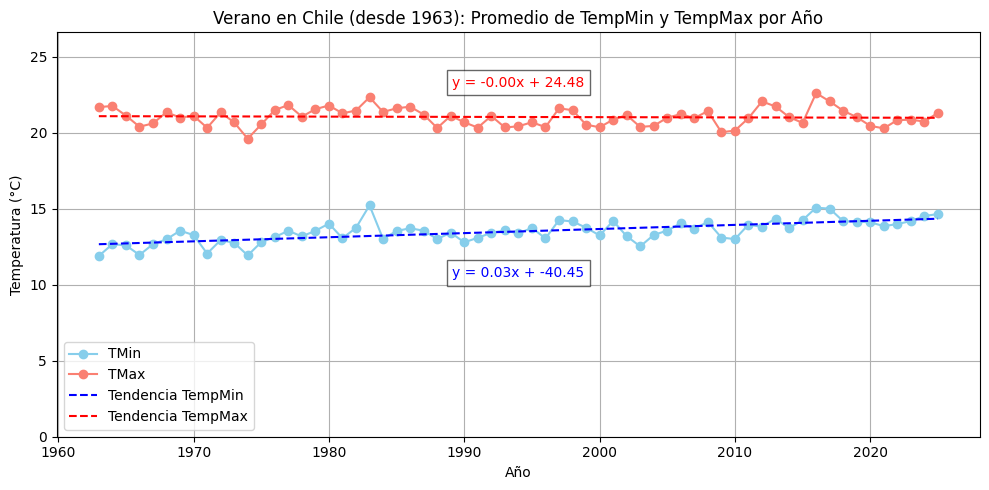

In [10]:
calcular_promedios_por_estacion(df_tmin, df_tmax, [12, 1, 2], "Verano")

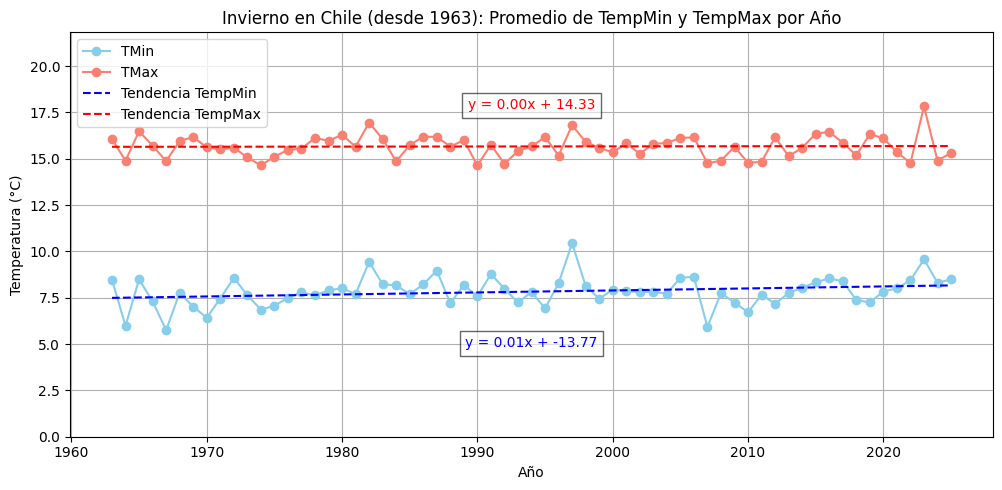

In [11]:
calcular_promedios_por_estacion(df_tmin, df_tmax, [6, 7, 8], "Invierno")

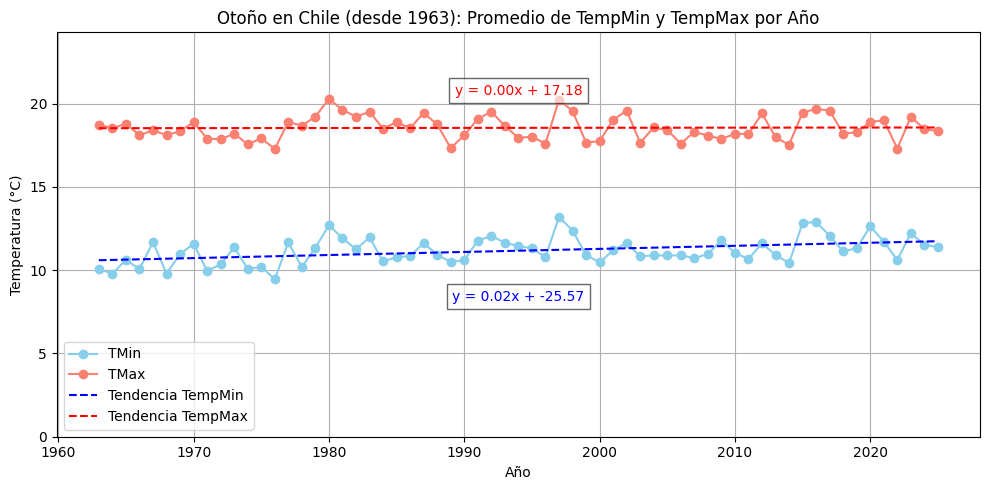

In [12]:
calcular_promedios_por_estacion(df_tmin, df_tmax, [3, 4, 5], "Otoño")

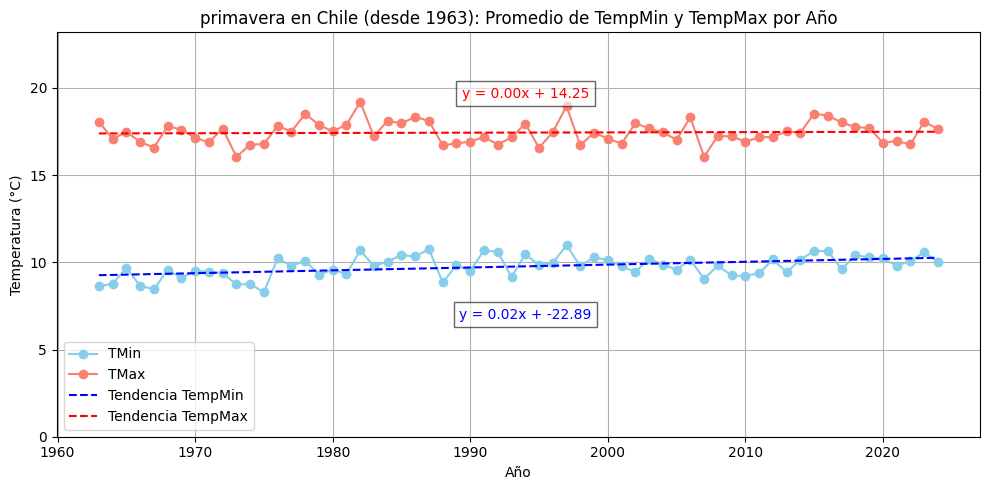

In [13]:
calcular_promedios_por_estacion(df_tmin, df_tmax, [9, 10, 11], "primavera")

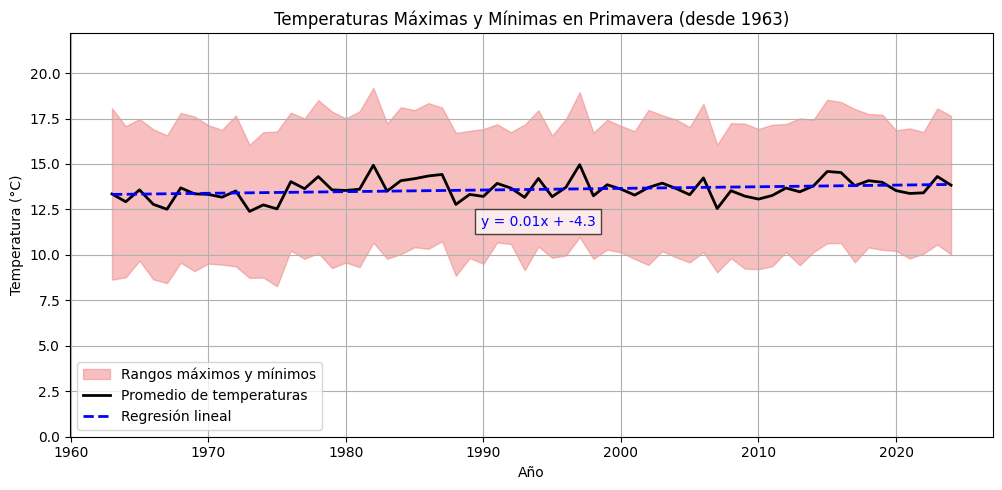

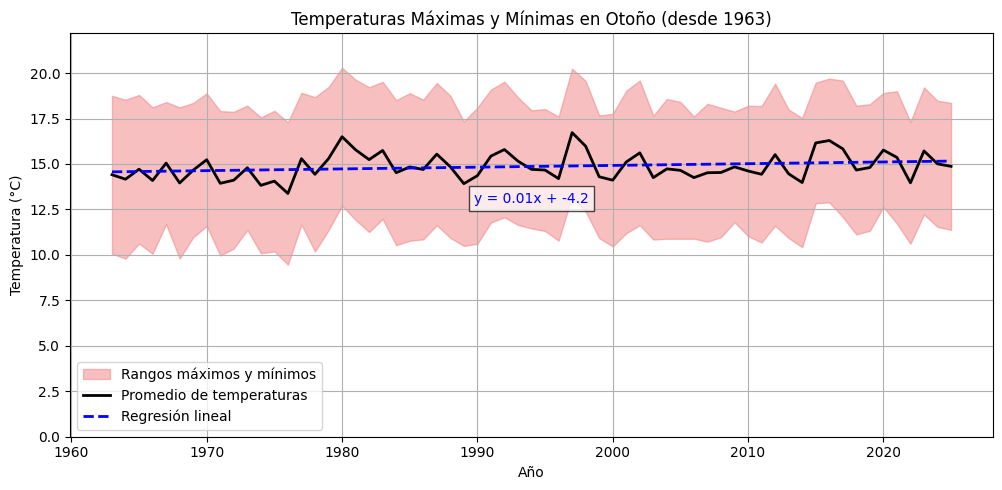

In [14]:
def graficar_fill_promedio_y_regresion(df_tmin, df_tmax, meses_estacion, nombre_estacion):
    # Filtrar por los meses de la estación
    df_tmin_est = df_tmin[df_tmin['Fecha'].dt.month.isin(
        meses_estacion)].copy()
    df_tmax_est = df_tmax[df_tmax['Fecha'].dt.month.isin(
        meses_estacion)].copy()

    # Agregar columna Año
    df_tmin_est['Año'] = df_tmin_est['Fecha'].dt.year
    df_tmax_est['Año'] = df_tmax_est['Fecha'].dt.year

    # Filtrar desde 1963
    df_tmin_est = df_tmin_est[df_tmin_est['Año'] >= 1963]
    df_tmax_est = df_tmax_est[df_tmax_est['Año'] >= 1963]

    # Agrupar y calcular promedios
    df_min_avg = df_tmin_est.groupby('Año')['TMin'].mean().reset_index()
    df_max_avg = df_tmax_est.groupby('Año')['TMax'].mean().reset_index()

    # Unir TMin y TMax
    df_merge = pd.merge(df_min_avg, df_max_avg, on='Año', how='inner')

    # Preparar datos
    x = df_merge['Año']
    y1 = df_merge['TMax']
    y2 = df_merge['TMin']
    y_central = (y1 + y2) / 2

    # Calcular regresión lineal sobre el promedio
    z = np.polyfit(x, y_central, 1)
    p = np.poly1d(z)

    # Graficar
    plt.figure(figsize=(10, 5))
    plt.fill_between(x, y1, y2, color='lightcoral', alpha=0.5,
                     label='Rangos máximos y mínimos')
    plt.plot(x, y_central, color='black', linewidth=2,
             label='Promedio de temperaturas')
    plt.plot(x, p(x), color='blue', linestyle='--',
             linewidth=2, label='Regresión lineal')

    # Mostrar ecuación de regresión
    x_middle = x.iloc[len(x) // 2]
    plt.text(x_middle, p(x_middle) + -2, f'y = {z[0]:.2f}x + {z[1]:.1f}',
             fontsize=10, color='blue', ha='center', bbox=dict(facecolor='white', alpha=0.7))

    # Etiquetas
    plt.title(
        f'Temperaturas Máximas y Mínimas en {nombre_estacion} (desde 1963)')
    plt.xlabel('Año')
    plt.ylabel('Temperatura (°C)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.ylim(bottom=0, top=y_max + 10)
    plt.show()


graficar_fill_promedio_y_regresion(df_tmin, df_tmax, [9, 10, 11], "Primavera")

graficar_fill_promedio_y_regresion(df_tmin, df_tmax, [3, 4, 5], "Otoño")

# La Serena - Santiago

## 🗂️📚 Contexto, descripción y fuentes de los datos utilizados 🔍🌐
### 🔸 Contexto y descripción del proyecto

Nuestro proyecto se enfocó en el análisis del comportamiento histórico de parámetros meteorológicos entre dos ciudades de Chile: La Serena (Región de Coquimbo) y Santiago (Quinta Normal, Región Metropolitana). Para ello utilizamos datos de estaciones meteorológicas oficiales:

- 📍 **Para La Serena**, datos de la estación **La Florida**.  
- 📍 **Para Santiago**, datos de la estación **Quinta Normal**.

El análisis tiene como objetivo identificar:

- Diferencias geográficas en el comportamiento térmico.  
- Tendencias temporales asociadas al cambio climático en cada entorno.  
- Patrones climáticos característicos de cada ciudad.

---


### 🔸 Pregunta a responder y fuente de los datos utilizados

Dentro del marco general de nuestro proyecto, una de las preguntas que nosotros buscamos responder es:

#### 🌡️📈 ¿Existe alguna tendencia de temperatura a lo largo de los años en ambas zonas de Chile? 🤔

Para responder esta pregunta, se utilizaron directamente archivos en formato CSV provenientes de las estaciones meteorológicas mencionadas anteriormente. Cada archivo contiene, por registro:

- Código identificatorio de la estación  
- Fecha y hora exacta de medición  
- Valor de temperatura instantánea registrada

Los datos fueron obtenidos desde el portal oficial de la **Dirección Meteorológica de Chile**, dependiente de la **Dirección General de Aeronáutica Civil (DGAC)**:

🔗 [https://climatologia.meteochile.gob.cl/application/requerimiento/producto/RE3008](https://climatologia.meteochile.gob.cl/application/requerimiento/producto/RE3008)

<img src= "images/gosth.png" width="2000" height="1000" alt="Descripción de la imagen">

## 🧹**Preparación de datos y su propósito en el proyecto** 🗂️📌

Para responder a la pregunta sobre si existe una tendencia en los cambios de temperatura a lo largo de los años en Santiago y La Serena, los datos pasaron por una fase de preparación que constó de lo siguiente:
**1. Carga y limpieza inicial de los datos**

Al cargar los archivos CSV de cada zona, estos tenian características que requerían limpieza:

- Separadores mixtos (; y ,)
- Encabezados mal formateados en la primera fila
- Columnas sin nombres asignados

Para una correcta interpretación, se indico ambos separadores para la lectura, se asignaron nombres a las columnas y se corrigió el formato de fechas.


In [15]:
# Cargar los archivos CSV, indicando múltiples separadores y saltando la primera fila malformateada
df_coquimbo = pd.read_csv("csv/290004_XXXX_Temperatura_.csv",
                          sep='[;,]', engine='python', skiprows=1, header=None)
df_santiago = pd.read_csv("csv/330020_XXXX_Temperatura_.csv",
                          sep='[;,]', engine='python', skiprows=1, header=None)

# Asignar nombres a las columnas
df_coquimbo.columns = ['CodigoNacional', 'momento', 'Ts_Valor']
df_santiago.columns = ['CodigoNacional', 'momento', 'Ts_Valor']

**2. Conversión temporal y filtrado por rango de análisis**

La columna de ("momento") se convirtió a una de tipo "datetime". Luego, se extrajeron los campos **Año** y **Mes** para poder usarlos en una agrupación posteriormente.

Como nuestro análisis se enfoca en **tendencias recientes**, se aplicó un filtro para conservar **únicamente los datos desde el año 2010** en adelante.


In [16]:
# Convertir la columna 'momento' al tipo datetime
df_coquimbo['momento'] = pd.to_datetime(df_coquimbo['momento'], dayfirst=True)
df_santiago['momento'] = pd.to_datetime(df_santiago['momento'], dayfirst=True)

# Extraer año y mes desde la columna de fechas
df_coquimbo['Año'] = df_coquimbo['momento'].dt.year
df_coquimbo['Mes'] = df_coquimbo['momento'].dt.month

df_santiago['Año'] = df_santiago['momento'].dt.year
df_santiago['Mes'] = df_santiago['momento'].dt.month

# Filtrar para quedarnos solo con los registros desde el año 2010
df_coquimbo = df_coquimbo[df_coquimbo['Año'] >= 2010]
df_santiago = df_santiago[df_santiago['Año'] >= 2010]

**3. Preparacion de las temperaturas medias anuales**

Se calcularon las medias anuales de temperatura para cada ciudad. De esta manera tenemos una **visión general** del comportamiento climatico a lo largo de los años y a la vez facilita la aplicación regresión lineal.

In [17]:
# Calcular la temperatura media anual para cada ciudad
coquimbo_anual = df_coquimbo.groupby('Año')['Ts_Valor'].mean().reset_index()
santiago_anual = df_santiago.groupby('Año')['Ts_Valor'].mean().reset_index()

**3. Preparacion de las temperaturas por estaciones del año**

A cada registro se le asignó una estación (primavera, verano, otoño, invierno) según el mes de medición. Asi calcululamos la **temperatura promedio por estación y año**, de esta manera podemos observar **cambios específicos en cada época del año**, detectando si el aumento de temperatura es mas brusco en una estación en particular.

In [18]:
# Función para asignar estación del año según el mes
def obtener_estacion(mes):
    if mes in [12, 1, 2]:
        return 'Verano'
    elif mes in [3, 4, 5]:
        return 'Otoño'
    elif mes in [6, 7, 8]:
        return 'Invierno'
    else:
        return 'Primavera'


# Aplicar la función a cada DataFrame
df_coquimbo['Estacion'] = df_coquimbo['Mes'].apply(obtener_estacion)
df_santiago['Estacion'] = df_santiago['Mes'].apply(obtener_estacion)

# Agrupar por Año y Estación para calcular temperatura promedio estacional
coquimbo_estacional = df_coquimbo.groupby(['Año', 'Estacion'])[
    'Ts_Valor'].mean().reset_index()
santiago_estacional = df_santiago.groupby(['Año', 'Estacion'])[
    'Ts_Valor'].mean().reset_index()

### 📉🔍 **Visualización de los datos y Conclusiones** 🧾📊

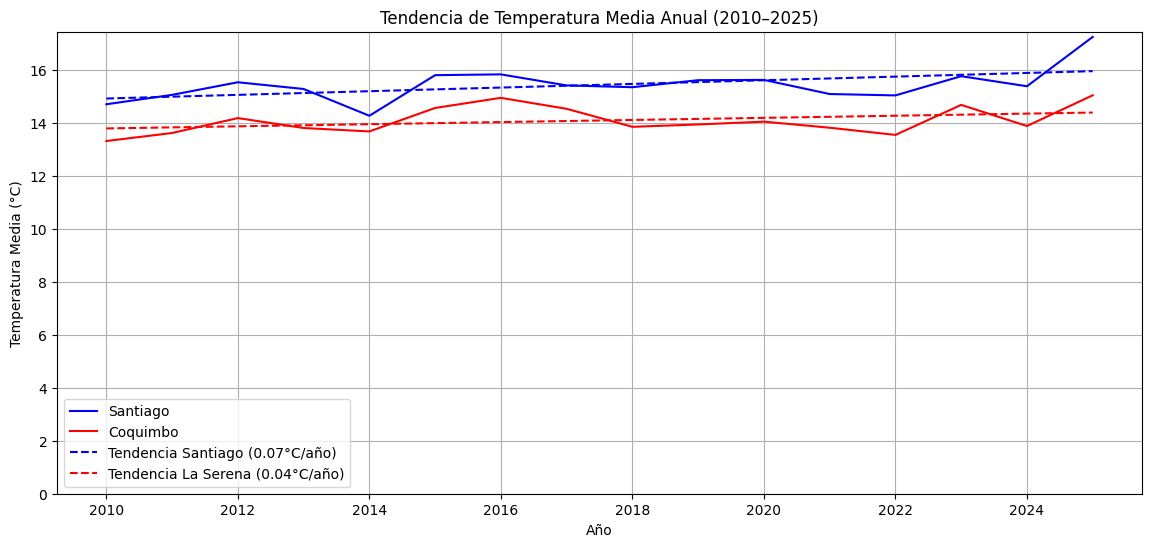

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Regresión lineal directamente sobre los datos ya filtrados
slope_s, intercept_s, _, _, _ = linregress(
    santiago_anual['Año'], santiago_anual['Ts_Valor'])
slope_c, intercept_c, _, _, _ = linregress(
    coquimbo_anual['Año'], coquimbo_anual['Ts_Valor'])

# Graficar
plt.figure(figsize=(14, 6))
sns.lineplot(data=santiago_anual, x='Año', y='Ts_Valor',
             label='Santiago', color='blue')
sns.lineplot(data=coquimbo_anual, x='Año', y='Ts_Valor',
             label='Coquimbo', color='red')

# Agregar líneas de tendencia
plt.plot(santiago_anual['Año'], slope_s * santiago_anual['Año'] + intercept_s,
         color='blue', linestyle='--', label=f'Tendencia Santiago ({slope_s:.2f}°C/año)')
plt.plot(coquimbo_anual['Año'], slope_c * coquimbo_anual['Año'] + intercept_c,
         color='red', linestyle='--', label=f'Tendencia La Serena ({slope_c:.2f}°C/año)')

# Personalización
plt.title('Tendencia de Temperatura Media Anual (2010–2025)')
plt.xlabel('Año')
plt.ylabel('Temperatura Media (°C)')
plt.ylim(0)
plt.grid(True)
plt.legend()
plt.show()

### **🌡️📈¿Existe una tendencia de temperatura a lo largo de los años en ambas zonas de Chile?**


En base a los datos y el grafico mostrado, podemos llegar a la conclusión, de que **si** existe la presencia de una tendencia de temperatura en ambas zonas, los ultimos 15 años. La regresion lineal aplicada sobre los datos, nos indica que la temperatura a aumentado de forma gradual tras los años, siendo la mas afectada Santiago con una media de aumento de 0.07 °C por año, y en el caso de de La Serena ha habido un aumento de 0.04 °C por año. En conjunto, los datos respaldan la existencia de una tendencia sostenida de aumento de temperatura en ambas zonas, lo cual es coherente con los efectos del cambio climático observados a nivel nacional y global.

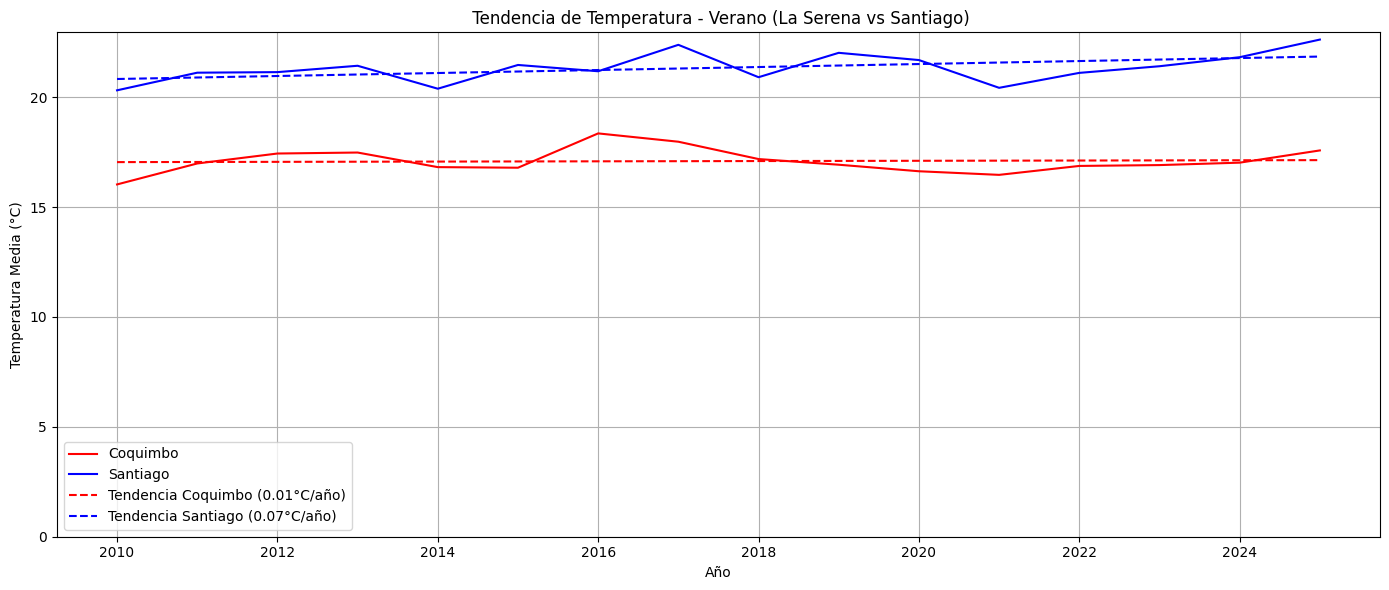

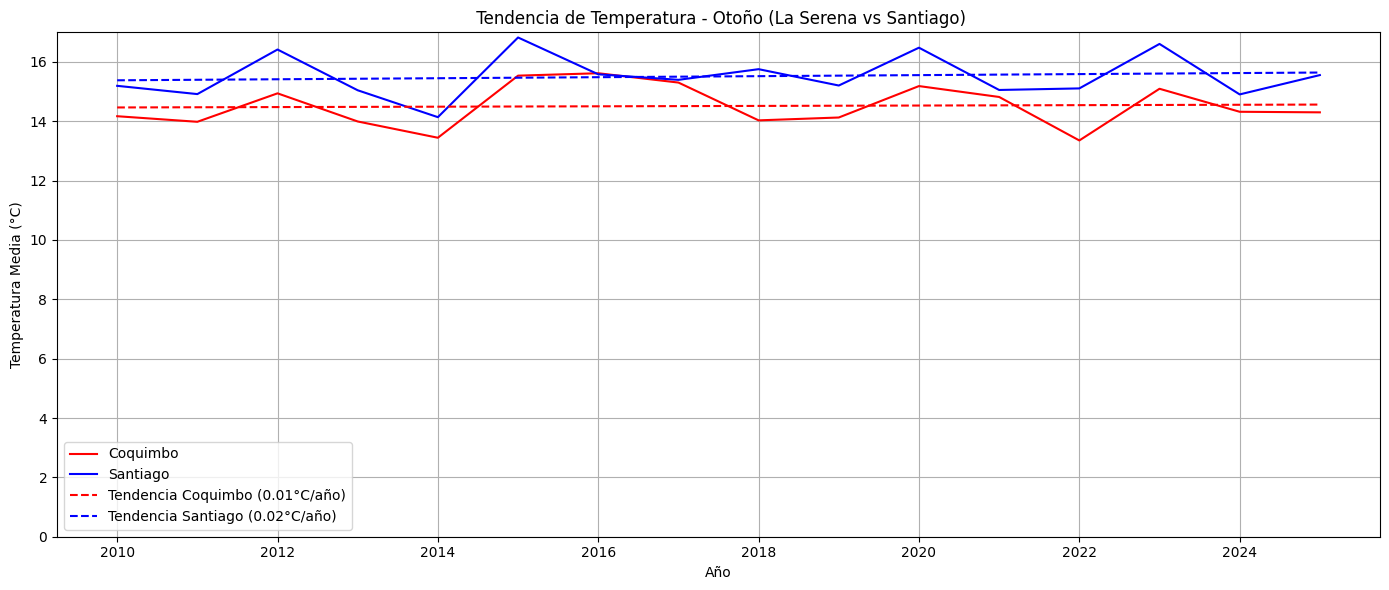

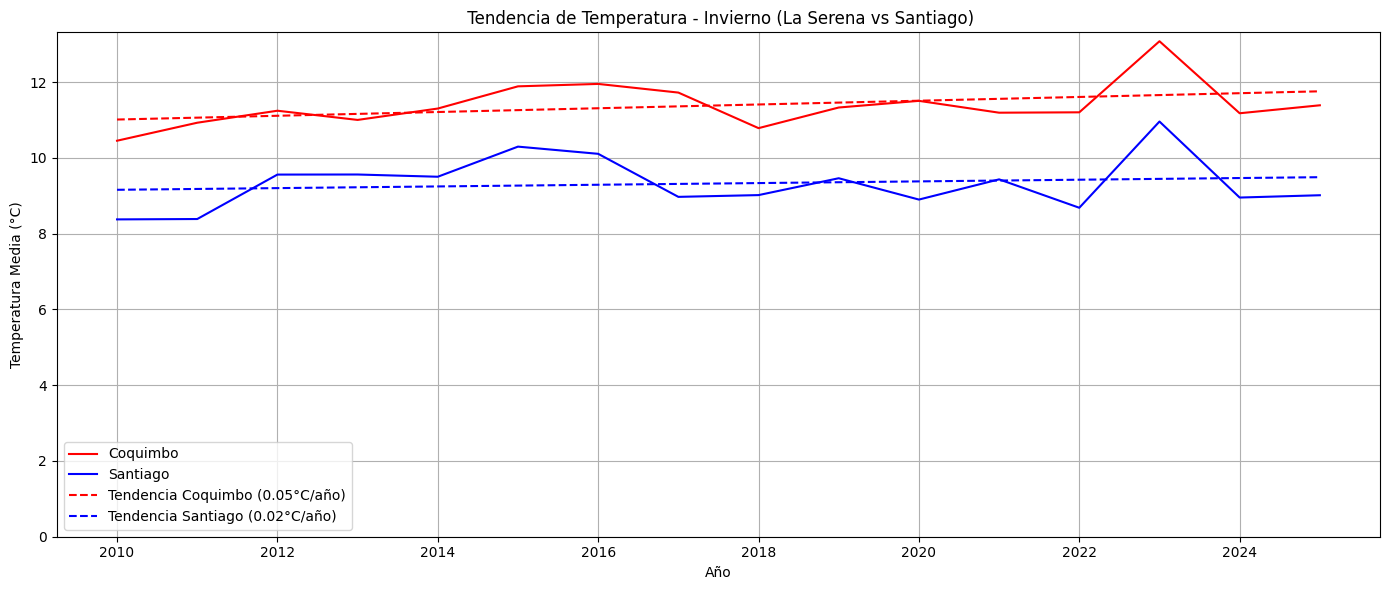

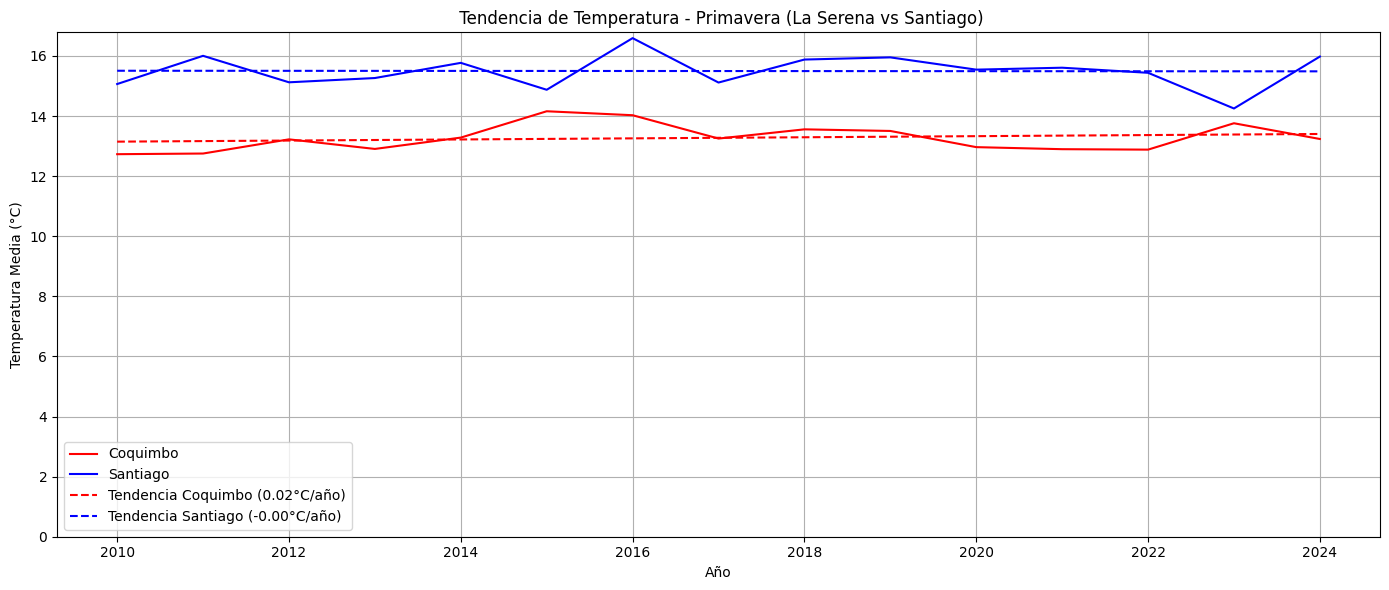

In [20]:
# Orden fijo de estaciones y colores
orden_estaciones = ['Verano', 'Otoño', 'Invierno', 'Primavera']
colores = {
    'Coquimbo': 'red',
    'Santiago': 'blue'
}

# Crear un gráfico por estación
for estacion in orden_estaciones:
    # Filtrar datos para la estación
    datos_c = coquimbo_estacional[coquimbo_estacional['Estacion'] == estacion]
    datos_s = santiago_estacional[santiago_estacional['Estacion'] == estacion]

    # Crear figura
    plt.figure(figsize=(14, 6))

    # Línea base de datos
    sns.lineplot(data=datos_c, x='Año', y='Ts_Valor',
                 label='Coquimbo', color=colores['Coquimbo'])
    sns.lineplot(data=datos_s, x='Año', y='Ts_Valor',
                 label='Santiago', color=colores['Santiago'])

    # Regresiones lineales
    pendiente_c, inter_c, _, _, _ = linregress(
        datos_c['Año'], datos_c['Ts_Valor'])
    pendiente_s, inter_s, _, _, _ = linregress(
        datos_s['Año'], datos_s['Ts_Valor'])

    # Líneas de tendencia
    plt.plot(datos_c['Año'], pendiente_c * datos_c['Año'] + inter_c,
             color=colores['Coquimbo'], linestyle='--', label=f'Tendencia Coquimbo ({pendiente_c:.2f}°C/año)')

    plt.plot(datos_s['Año'], pendiente_s * datos_s['Año'] + inter_s,
             color=colores['Santiago'], linestyle='--', label=f'Tendencia Santiago ({pendiente_s:.2f}°C/año)')

    # Personalizar gráfico
    plt.title(
        f' Tendencia de Temperatura - {estacion} (La Serena vs Santiago)')
    plt.xlabel('Año')
    plt.ylabel('Temperatura Media (°C)')
    plt.ylim(0)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### ☀️❓❄️ **¿Los veranos se están volviendo más calurosos? ¿Qué estación del año muestra mayor aumento de temperatura en Santiago y La Serena?** 📊

El analisis por estaciones muestra que los cambios no se dan de manera uniforme para todas ellas, sino que en ambas ciudades las temperaturas incrementan con mayor intensidad dependiendo de la estacion en que se encuentren, primeramente tenemos que los veranos han aumentado progresivamente para Santiago de una forma mas agresiva si comparamos con La Serena, ya que para Santiago ha ido aumentando 0.07 °c por año mientras que en La Serena las temperarutas se han mantenido mas estable en esta estacion, contando con un aumento de 0.01 °c por año.Entonces los veranos para Santiago se han vuelto mucho mas calurosos, tanto asi que es la estacion con mayor cambio de temperatura para la ciudad tras los ultimos 15 años, mientras que La Serena se puede observar como la estacion ccon mayor cambio de temperatura ha sido el invierno con un 0.05°C por año. En conclusión podemos ver que la temperatura aumenta segun la estacion del año y que el verano en Santiago y el invierno en La Serena son los mas afectados.

# Análisis de la Evolución de Temperaturas en Santiago (2010-2025)

## 1. Contexto, descripción y fuentes de los datos utilizados

Para analizar la evolución de las temperaturas en la región de Santiago entre 2010 y 2025, se utilizaron datos históricos de temperaturas mínimas y máximas  obtenidos de la Dirección General de Aeronáutica Civil (DGAC) de Chile.
 
Estos datos corresponden a registros oficiales de estaciones meteorológicas , almacenados en archivos CSV con formato separado por punto y coma (“;”).  
La DGAC es una fuente  que provee información meteorológica para distintos fines aeronáuticos y de investigación ambiental y representatividad de los datos.

Los datos fueron obtenidos desde la Dirección Meteorológica de Chile, dependiente de la Dirección General de Aeronáutica Civil (DGAC):
[https://climatologia.meteochile.gob.cl/application/informacion/fichaDeEstacion/330020](https://climatologia.meteochile.gob.cl/application/informacion/fichaDeEstacion/330020)

## 2. Preparación y procesamiento de los datos 
 - Lectura y separación de datos desde archivos CSV.
 - Conversión de fechas y temperaturas a formatos adecuados.
 - Unión de datos de Tmin y Tmax por fecha.
 - Cálculo de temperatura promedio diaria.
 - Se realizo el filtrado para los años 2010 a 2025.

In [21]:
def procesar_datos(ruta_min, ruta_max):
    col_min = pd.read_csv(ruta_min).iloc[:, 0].str.split(';', expand=True)
    col_max = pd.read_csv(ruta_max).iloc[:, 0].str.split(';', expand=True)

    df_min = pd.DataFrame({
        'fecha': pd.to_datetime(col_min[1], format='%d-%m-%Y %H:%M:%S', errors='coerce').dt.date,
        'Tmin': pd.to_numeric(col_min[2], errors='coerce')
    })

    df_max = pd.DataFrame({
        'fecha': pd.to_datetime(col_max[1], format='%d-%m-%Y %H:%M:%S', errors='coerce').dt.date,
        'Tmax': pd.to_numeric(col_max[2], errors='coerce')
    })

    df = pd.merge(df_min, df_max, on='fecha').dropna()
    df['año'] = pd.to_datetime(df['fecha']).dt.year
    df = df[(df['año'] >= 2010) & (df['año'] <= 2025)]
    df['Tprom'] = (df['Tmin'] + df['Tmax']) / 2
    return df

# Cargar datos
santiago_df = procesar_datos('csv/330020_XXXX_TMinima_.csv',
                             'csv/330020_XXXX_TMaxima_.csv')


## 3. Visualización: Distribución de temperaturas con Boxplot

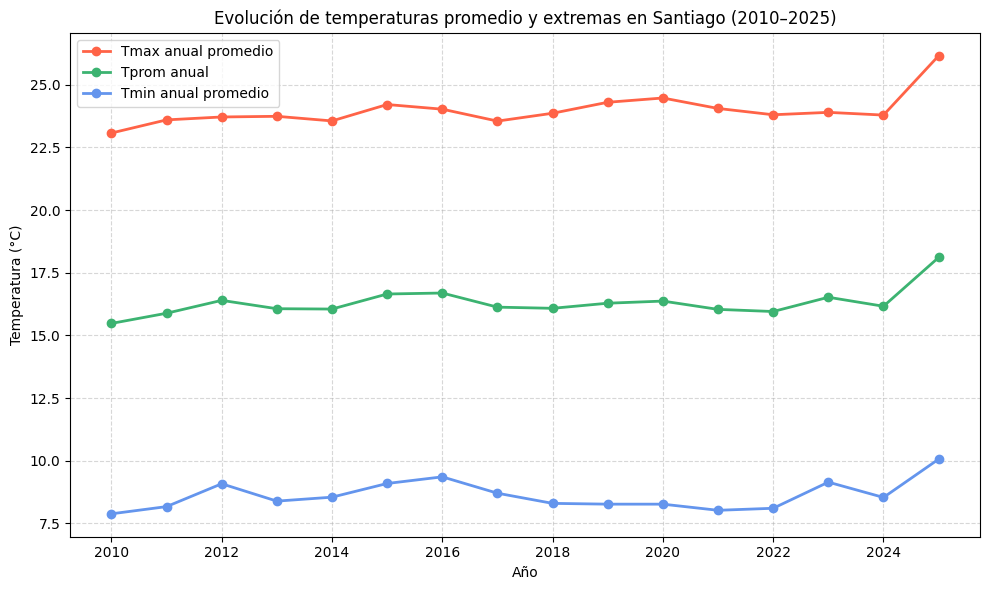

In [22]:

df_anual = santiago_df.groupby('año').agg({
    'Tprom': 'mean',
    'Tmax': 'mean',
    'Tmin': 'mean'
}).reset_index()

plt.figure(figsize=(10, 6))

plt.plot(df_anual['año'], df_anual['Tmax'], marker='o', label='Tmax anual promedio', color='tomato', linewidth=2)
plt.plot(df_anual['año'], df_anual['Tprom'], marker='o', label='Tprom anual', color='mediumseagreen', linewidth=2)
plt.plot(df_anual['año'], df_anual['Tmin'], marker='o', label='Tmin anual promedio', color='cornflowerblue', linewidth=2)

plt.title('Evolución de temperaturas promedio y extremas en Santiago (2010–2025)')
plt.xlabel('Año')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 4. Cálculo del cambio en la temperatura promedio anual

In [23]:
df_anual = santiago_df.groupby('año').agg({'Tprom': 'mean'}).reset_index()

primer_año = df_anual['año'].min()
ultimo_año = df_anual['año'].max()

prom_primero = df_anual.loc[df_anual['año'] == primer_año, 'Tprom'].values[0]
prom_ultimo = df_anual.loc[df_anual['año'] == ultimo_año, 'Tprom'].values[0]

cambio = prom_ultimo - prom_primero

print(f"Entre {primer_año} y {ultimo_año}, la temperatura promedio anual en Santiago aumentó {cambio:.2f} °C.")

Entre 2010 y 2025, la temperatura promedio anual en Santiago aumentó 2.63 °C.


## 5. Respuesta breve a la hipótesis

In [24]:
respuesta = f"""
En Santiago, entre {primer_año} y {ultimo_año} las temperaturas promedio anuales aumentaron aproximadamente {cambio:.2f} °C. 
El boxplot muestra que las temperaturas extremas (máximas y mínimas) presentan una mayor variabilidad,
reflejando años cada vez más calurosos y cambios más marcados, lo que indica una tendencia general al 
calentamiento regional.
"""
print(respuesta)


En Santiago, entre 2010 y 2025 las temperaturas promedio anuales aumentaron aproximadamente 2.63 °C. 
El boxplot muestra que las temperaturas extremas (máximas y mínimas) presentan una mayor variabilidad,
reflejando años cada vez más calurosos y cambios más marcados, lo que indica una tendencia general al 
calentamiento regional.

